In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import boxcox, poisson
import matplotlib.pyplot as plt

In [2]:
# Load the CSV with hospital capacity rates for 2024
file_path = 'bor_2324_data.csv'
bor_2324_df = pd.read_csv(file_path)

# Ensure 'Date' column is treated as datetime
bor_2324_df['Date'] = pd.to_datetime(bor_2324_df['Date'], errors='coerce')

# List of hospitals
hospitals = ['AH', 'CGH', 'KTPH', 'NTFGH', 'NUH(A)', 'SGH', 'SKH', 'TTSH', 'WH']

/var/folders/fm/z4bvlq0156j1zcbvxdtb6nkm0000gn/T/ipykernel_84976/2802565099.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bor_2324_df['Date'] = pd.to_datetime(bor_2324_df['Date'], errors='coerce')


In [3]:
# Apply Box-Cox transformation to the data for each hospital
boxcox_results = {}
for hospital in hospitals:
    data = pd.to_numeric(bor_2324_df[hospital], errors='coerce').dropna()
    data = data[data > 0]  # Box-Cox transformation requires positive values
    transformed_data, lambda_val = boxcox(data)
    boxcox_results[hospital] = {'transformed_data': transformed_data, 'lambda': lambda_val}

# Monte Carlo simulation with Box-Cox transformed data
num_simulations = 1000  # Running 1000 simulations per hospital
time_steps = 24  # 2-hour intervals over a 24-hour period (12 steps)

Simulation with random step change

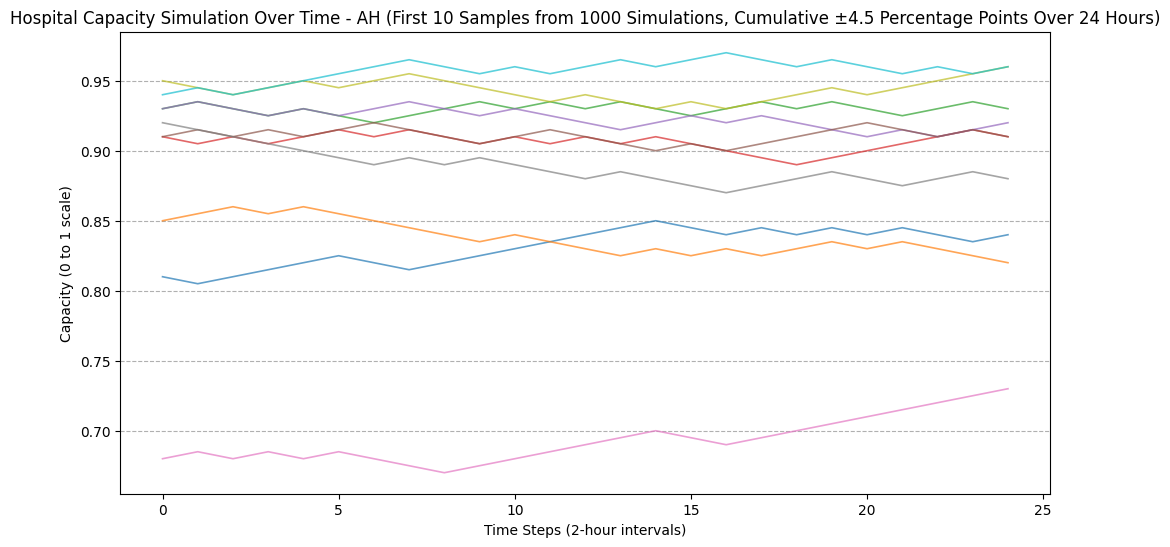

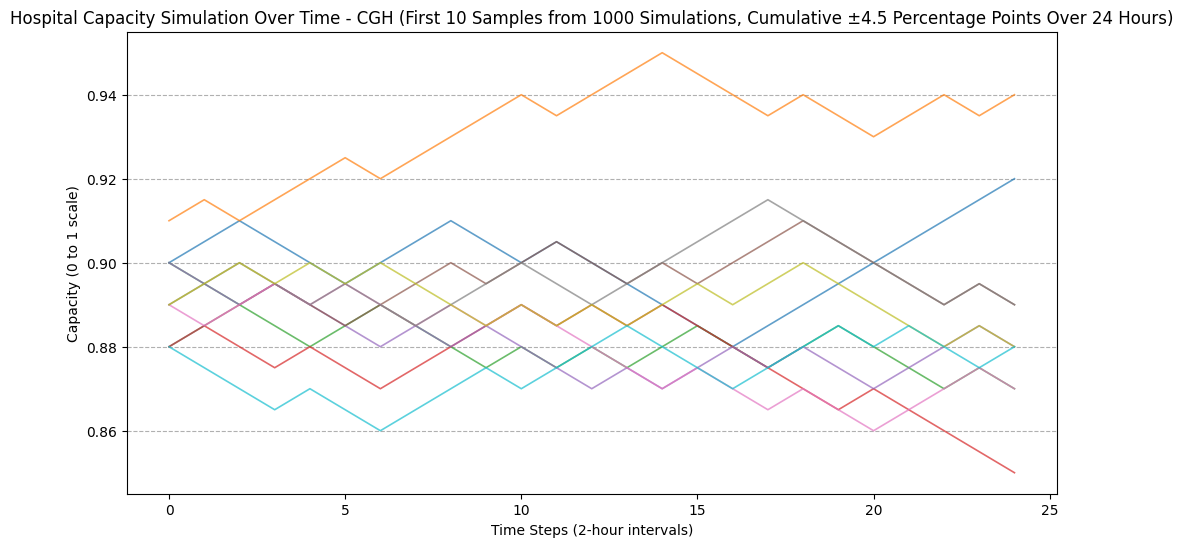

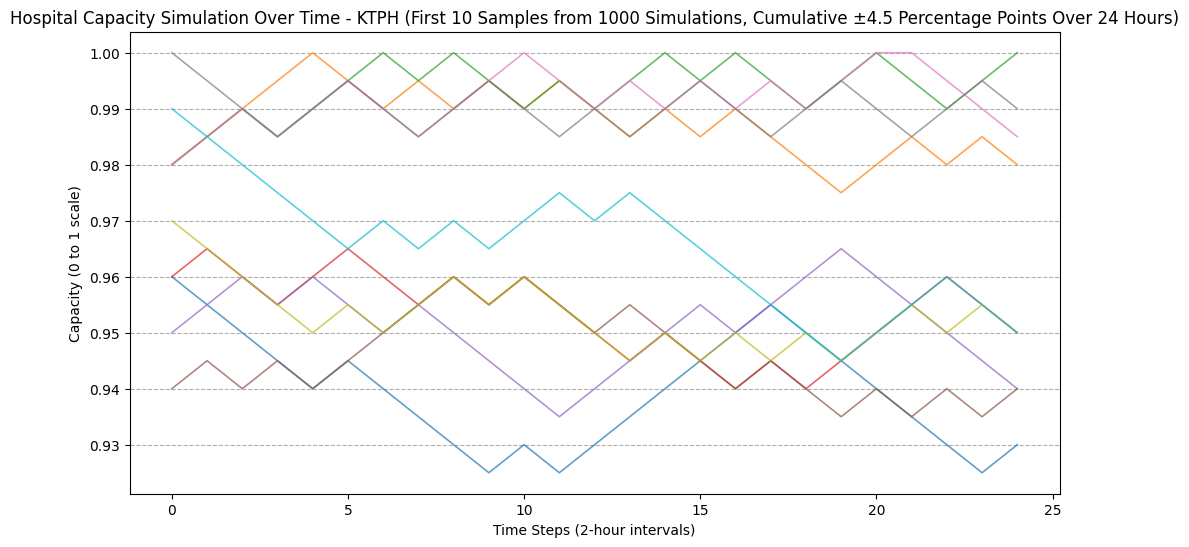

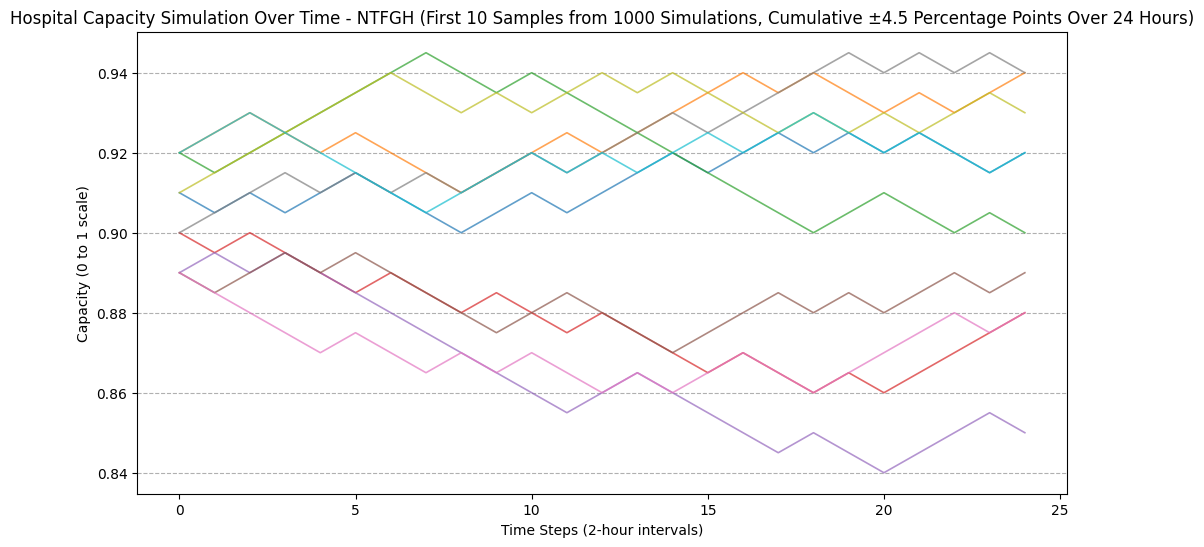

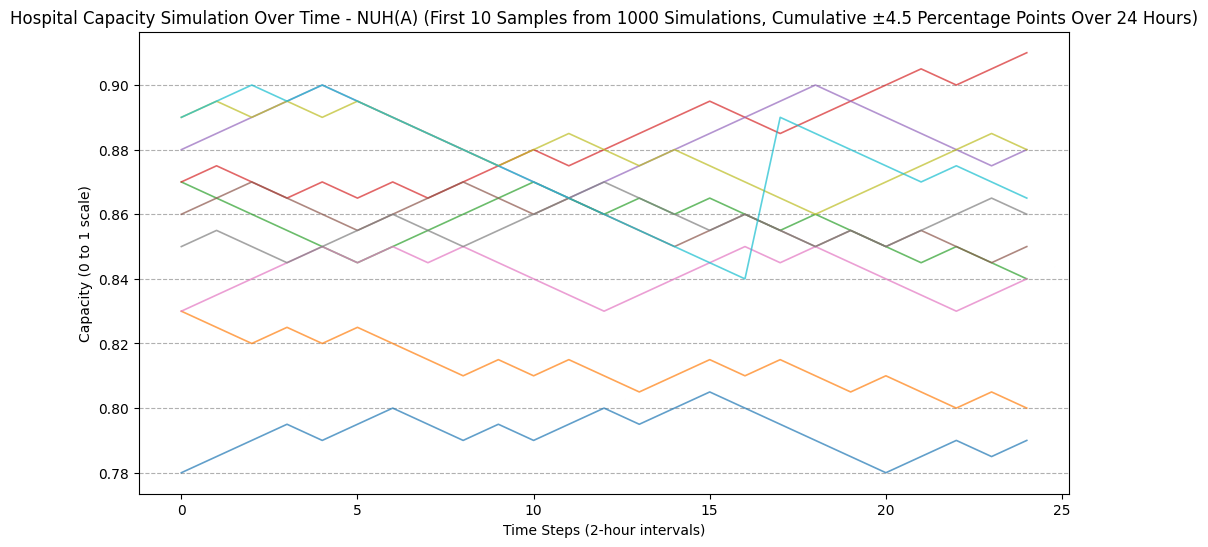

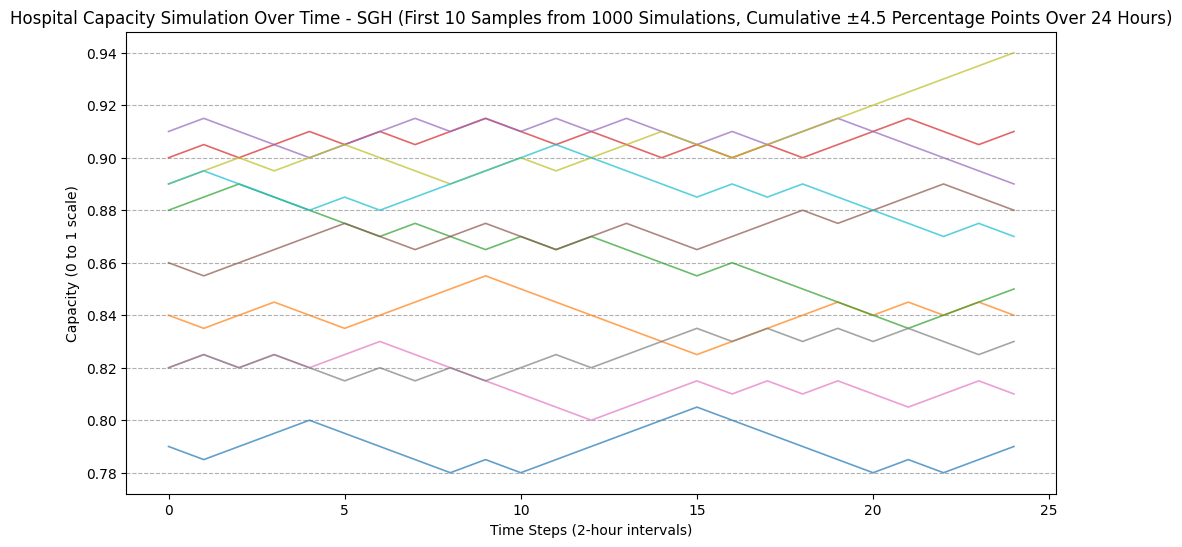

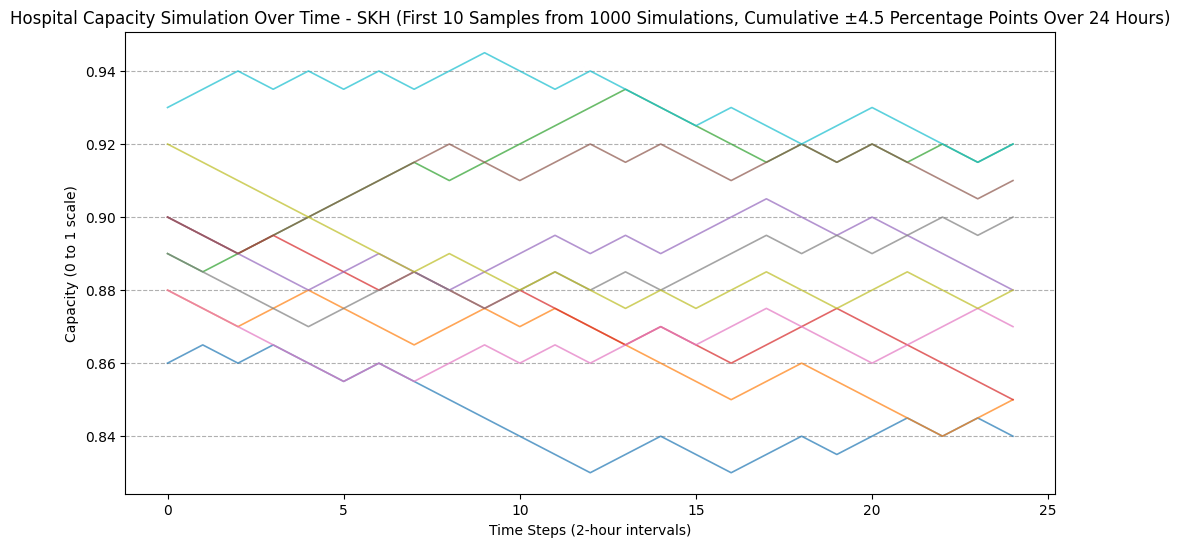

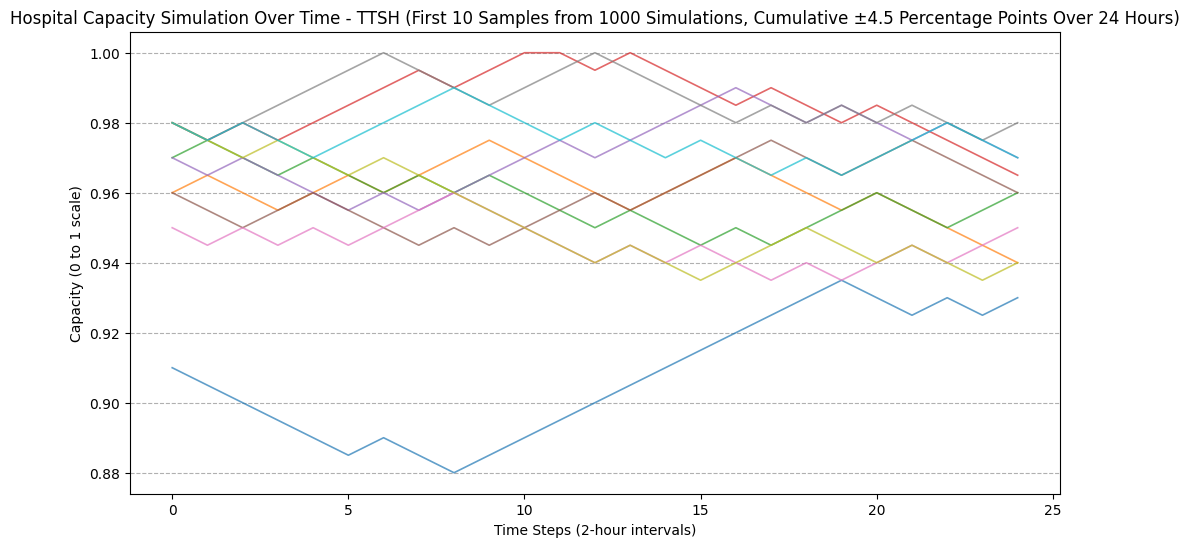

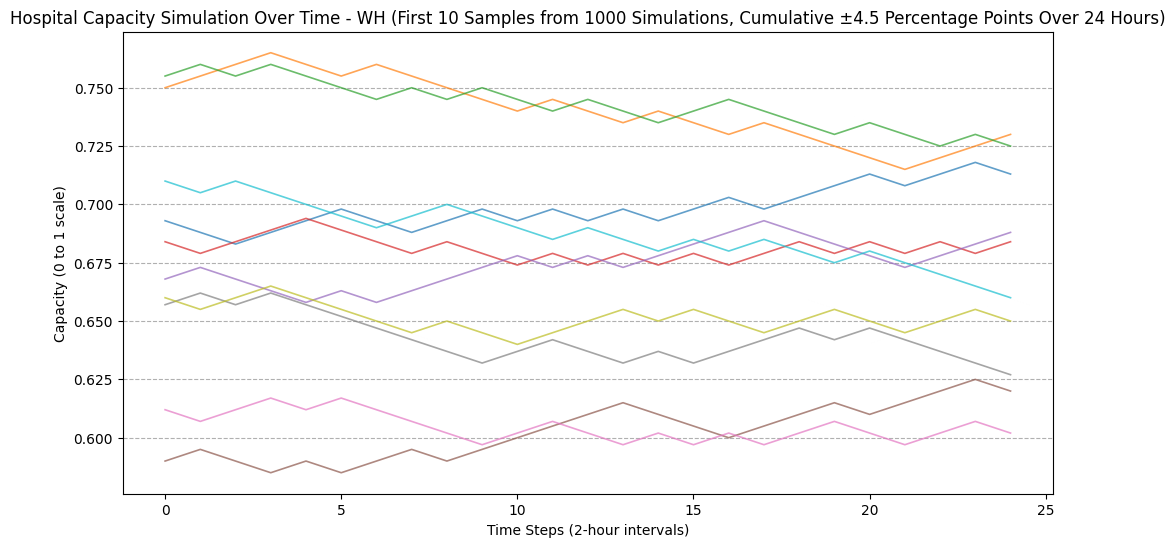

In [4]:
# Dictionary to store capacity over time for each hospital
hospital_capacity_simulation = {}

for hospital in hospitals:
    # Get the initial capacity samples from the Box-Cox-transformed data (take 10 samples for plotting)
    initial_capacity_samples = boxcox_results[hospital]['transformed_data'][:num_simulations]
    lambda_val = boxcox_results[hospital]['lambda']

    # Running the simulation for each of the initial capacity samples
    simulated_capacity_over_time = []

    for initial_capacity in initial_capacity_samples:
        # Back-transform to the original scale
        if lambda_val != 0:
            capacity = ((initial_capacity * lambda_val) + 1) ** (1 / lambda_val)
        else:
            capacity = np.exp(initial_capacity)

        # Initialize with the starting capacity
        capacity_over_time = [capacity]

        # Set constraints for cumulative change over the day
        cumulative_change_limit = 0.045  # ±4.5 percentage points
        cumulative_change = 0

        # Simulate for each time step (2-hour intervals, 12 steps per day)
        for t in range(time_steps):
            # Randomly decide whether to add or remove patients
            change_direction = np.random.choice([-1, 1])

            # Generate change magnitude with a maximum fluctuation of ±0.5% (0.005)
            delta_capacity = change_direction * 0.005

            # Ensure cumulative change does not exceed ±4.5 percentage points
            if abs(cumulative_change + delta_capacity) > cumulative_change_limit:
                # Adjust the direction or size of the change if it exceeds the limit
                delta_capacity = -cumulative_change if abs(cumulative_change) > cumulative_change_limit else delta_capacity

            # Update the capacity and cumulative change, ensuring capacity is non-negative and max at 1
            capacity = max(0, min(1, capacity + delta_capacity))
            cumulative_change += delta_capacity

            # Append the capacity at this time step
            capacity_over_time.append(capacity)

        simulated_capacity_over_time.append(capacity_over_time)

    # Store the results for this hospital
    hospital_capacity_simulation[hospital] = simulated_capacity_over_time

# Plotting the results for each hospital
for hospital in hospitals:
    plt.figure(figsize=(12, 6))
    for sim in range(10):  # Plotting 10 trajectories to see the trend for each hospital
        plt.plot(range(time_steps + 1), hospital_capacity_simulation[hospital][sim], alpha=0.7, linewidth=1.2)

    plt.title(f'Hospital Capacity Simulation Over Time - {hospital} (First 10 Samples from 1000 Simulations, Cumulative ±4.5 Percentage Points Over 24 Hours)')
    plt.xlabel('Time Steps (2-hour intervals)')
    plt.ylabel('Capacity (0 to 1 scale)')
    plt.grid(axis='y', linestyle='--')
    plt.show()


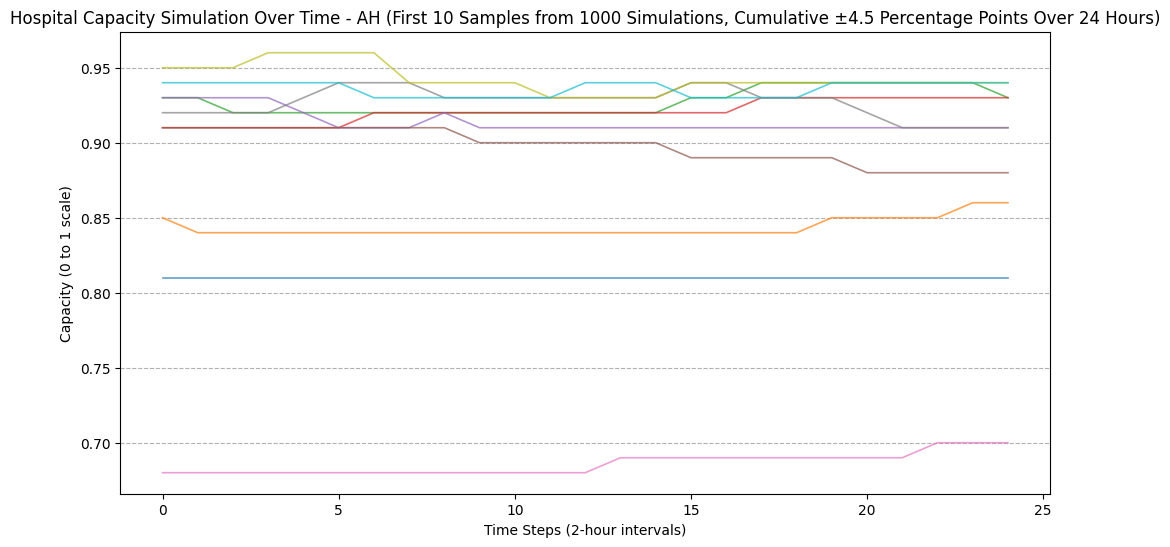

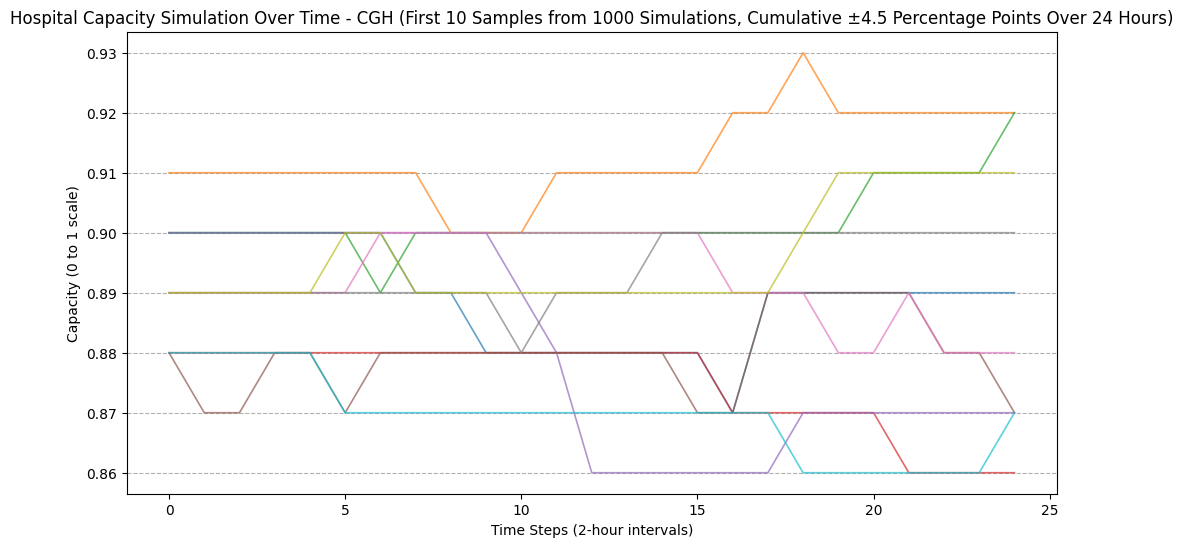

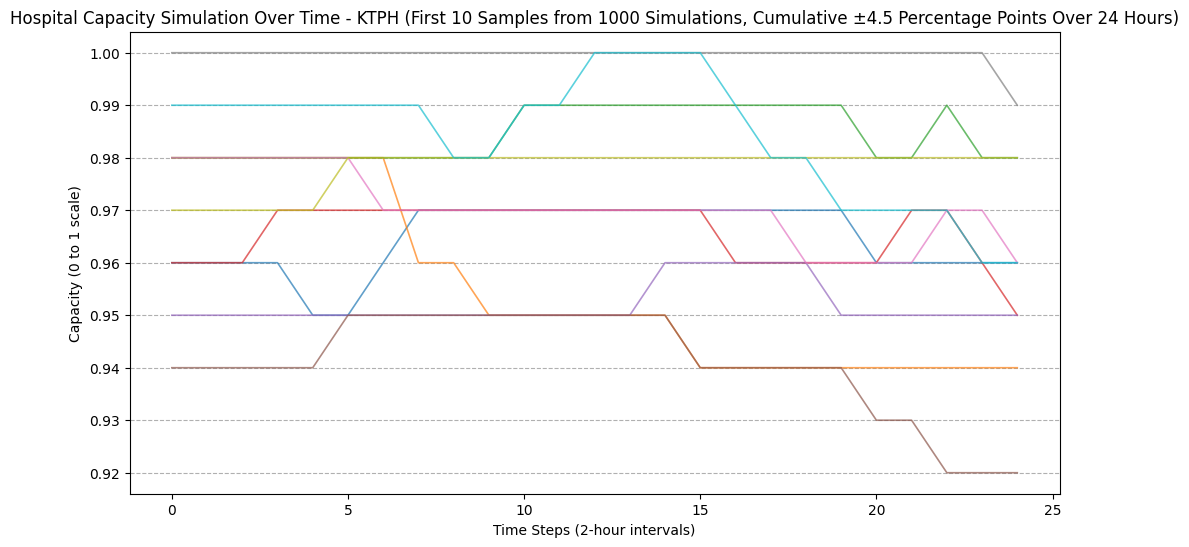

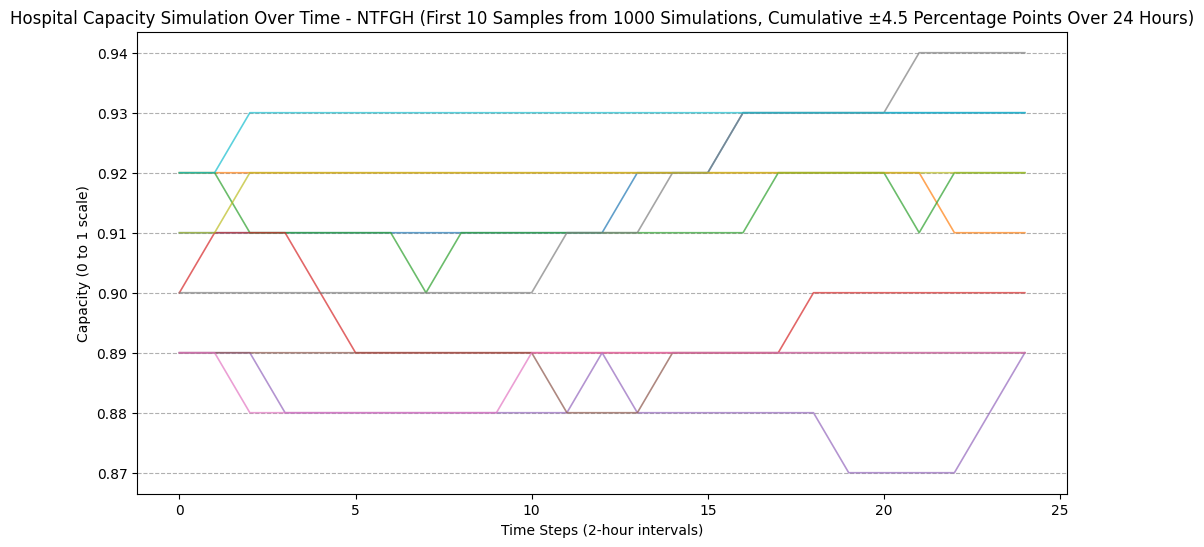

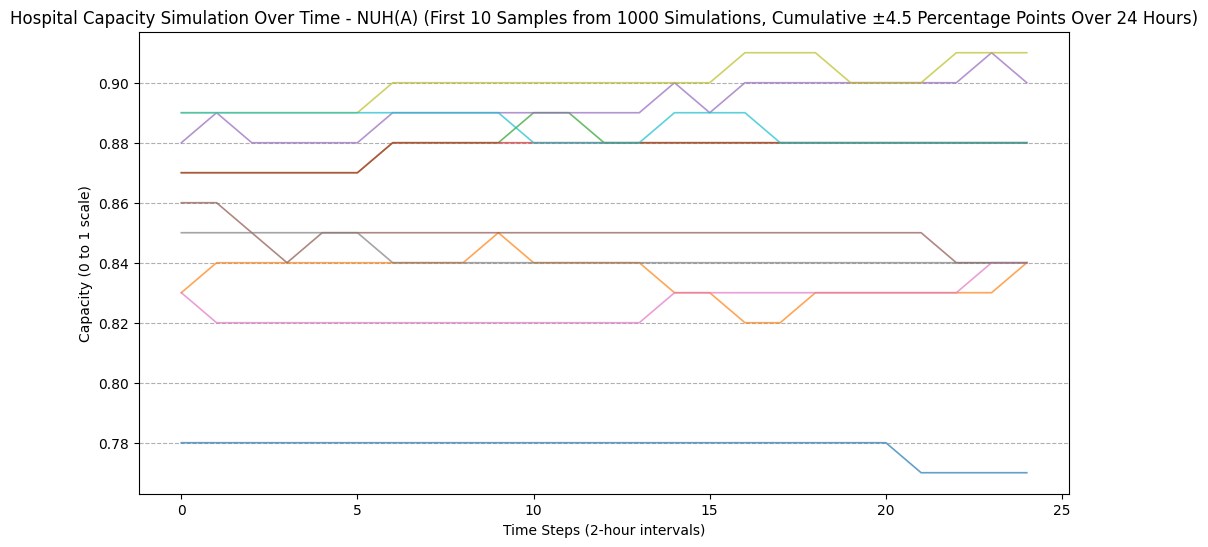

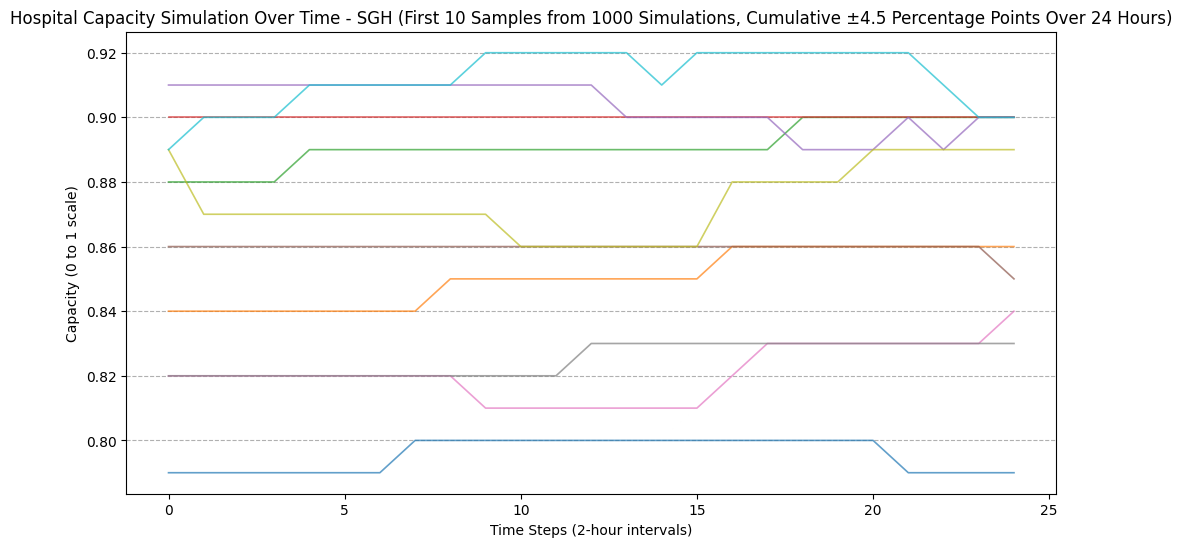

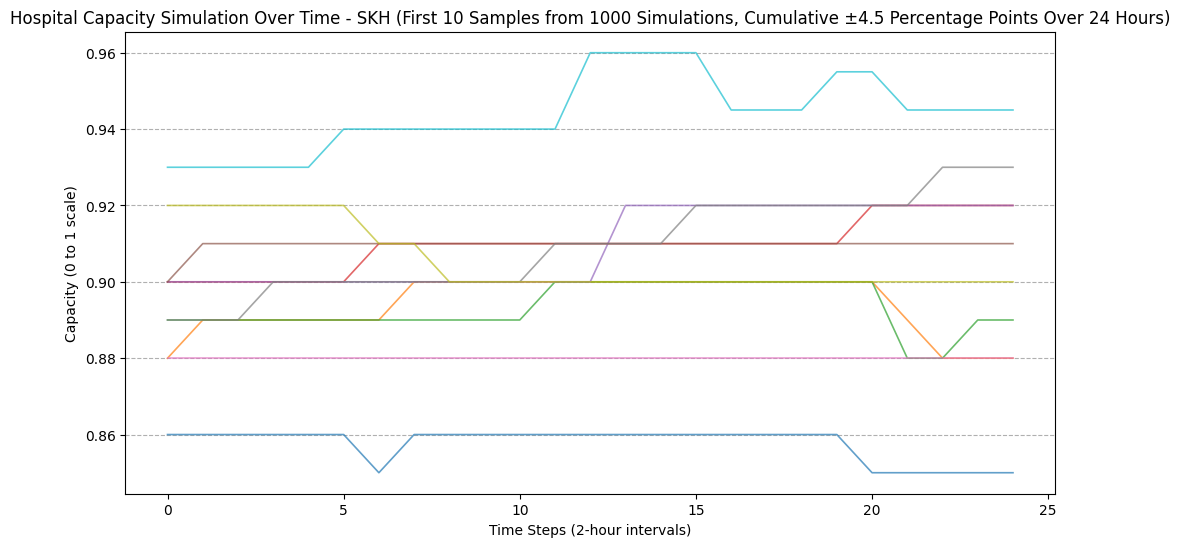

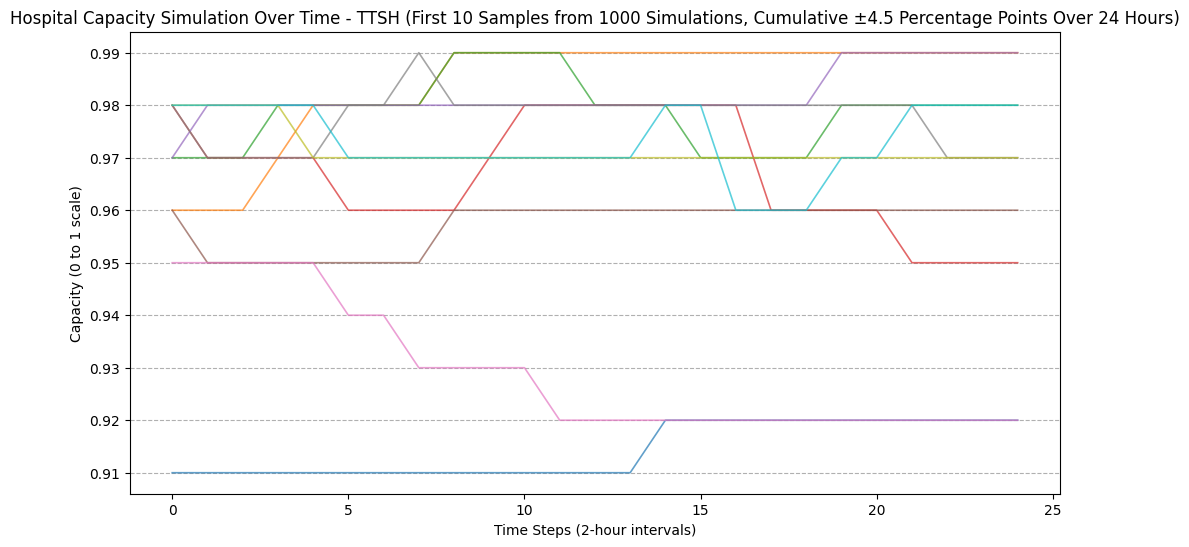

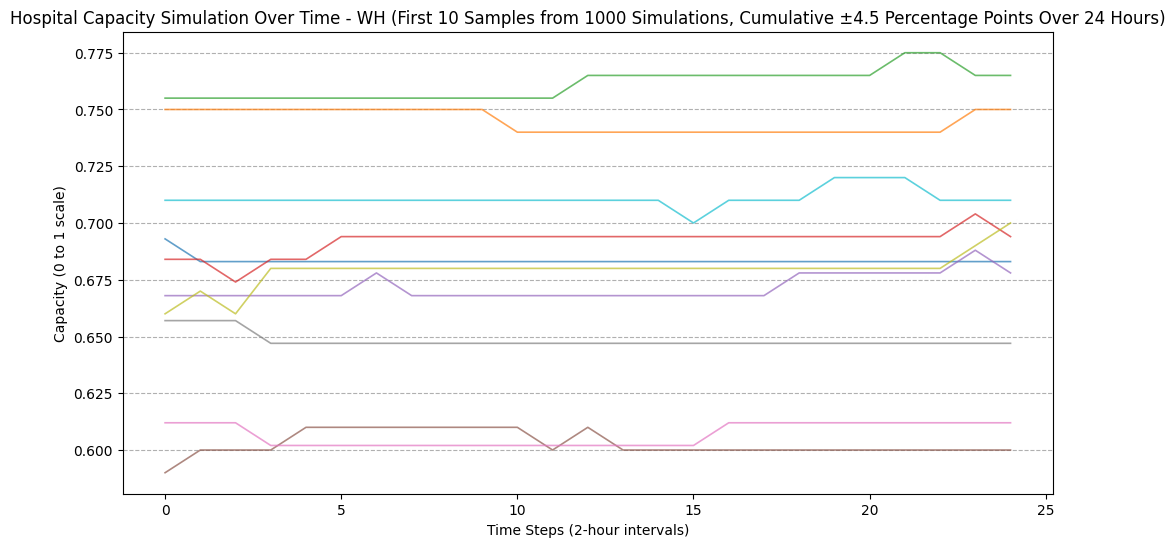

In [5]:
# Dictionary to store capacity over time for each hospital
hospital_capacity_simulation = {}

for hospital in hospitals:
    # Get the initial capacity samples from the Box-Cox-transformed data (take 10 samples for plotting)
    initial_capacity_samples = boxcox_results[hospital]['transformed_data'][:num_simulations]
    lambda_val = boxcox_results[hospital]['lambda']

    # Running the simulation for each of the initial capacity samples
    simulated_capacity_over_time = []

    for initial_capacity in initial_capacity_samples:
        # Back-transform to the original scale
        if lambda_val != 0:
            capacity = ((initial_capacity * lambda_val) + 1) ** (1 / lambda_val)
        else:
            capacity = np.exp(initial_capacity)

        # Initialize with the starting capacity
        capacity_over_time = [capacity]

        # Set constraints for cumulative change over the day
        cumulative_change_limit = 0.045  # ±4.5 percentage points
        cumulative_change = 0

        # Simulate for each time step (2-hour intervals, 12 steps per day)
        for t in range(time_steps):
            # Randomly decide whether to add or remove patients using a Poisson distribution
            lambda_rate = 0.15  # Increased average rate of change for each 2-hour interval to generate more variability
            delta_capacity = poisson.rvs(lambda_rate) / 100.0  # Generate change as a percentage
            change_direction = np.random.choice([-1, 1])
            delta_capacity *= change_direction

            # Ensure cumulative change does not exceed ±4.5 percentage points from original capacity
            if abs(cumulative_change + delta_capacity) > cumulative_change_limit:
                # Adjust the direction to stay within the limit
                delta_capacity = -np.sign(cumulative_change) * min(abs(delta_capacity), cumulative_change_limit - abs(cumulative_change))

            # Update the capacity and cumulative change, ensuring capacity is non-negative and max at 1
            capacity = max(0, min(1, capacity + delta_capacity))
            cumulative_change += delta_capacity

            # Append the capacity at this time step
            capacity_over_time.append(capacity)

        simulated_capacity_over_time.append(capacity_over_time)

    # Store the results for this hospital
    hospital_capacity_simulation[hospital] = simulated_capacity_over_time

# Plotting the results for each hospital
for hospital in hospitals:
    plt.figure(figsize=(12, 6))
    for sim in range(10):  # Plotting 10 trajectories to see the trend for each hospital
        plt.plot(range(time_steps + 1), hospital_capacity_simulation[hospital][sim], alpha=0.7, linewidth=1.2)

    plt.title(f'Hospital Capacity Simulation Over Time - {hospital} (First 10 Samples from 1000 Simulations, Cumulative ±4.5 Percentage Points Over 24 Hours)')
    plt.xlabel('Time Steps (2-hour intervals)')
    plt.ylabel('Capacity (0 to 1 scale)')
    plt.grid(axis='y', linestyle='--')
    plt.show()
